In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def get_mnist_dataloader(batch_size: int = 64, num_workers: int = 2, seed: int = 42):
    torch.manual_seed(seed)

    # MNIST: 28x28 grayscale; map pixels from [0,1] -> [-1,1] for tanh generator output
    transform = transforms.Compose([
        transforms.ToTensor(),                  # [0,1]
        transforms.Normalize(mean=0.5, std=0.5) # -> [-1,1]
    ])

    train_set = datasets.MNIST(
        root="./data",
        train=True,
        download=True,
        transform=transform
    )

    loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=False  # set True if using CUDA for the discriminator
    )
    return loader

if __name__ == "__main__":
    dl = get_mnist_dataloader(batch_size=64, num_workers=2)
    imgs, labels = next(iter(dl))
    print(imgs.shape, imgs.min().item(), imgs.max().item())  # torch.Size([64, 1, 28, 28]) ~ -1.0 to +1.0

torch.Size([64, 1, 28, 28]) -1.0 1.0


In [20]:
import torch
import torch.nn as nn

# Weight initialization (DCGAN-style)

def init_weights_normal(m, std: float = 0.02):
    if isinstance(m, (nn.Linear,)):
        nn.init.normal_(m.weight, mean=0.0, std=std)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.BatchNorm1d,)):
        nn.init.normal_(m.weight, mean=1.0, std=std)
        nn.init.zeros_(m.bias)

# Generator: z(100) -> 784, tanh
# Example width: 100 -> 256 -> 512 -> 784

class Generator(nn.Module):
    def __init__(self, z_dim: int = 100, img_dim: int = 28*28, hidden_dims=(256, 512), use_bn: bool = True):
        super().__init__()
        layers = []
        prev = z_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev, h), nn.ReLU(inplace=True)]
            if use_bn:
                layers.insert(-1, nn.BatchNorm1d(h))  # BN before ReLU is common in DCGAN
            prev = h
        layers += [nn.Linear(prev, img_dim), nn.Tanh()]
        self.net = nn.Sequential(*layers)
        self.apply(init_weights_normal)

    def forward(self, z):
        x = self.net(z)
        return x.view(z.size(0), 1, 28, 28)  # reshape to image


# Discriminator: 784 -> 256 -> 256 -> 1, LeakyReLU, Sigmoid
# Optional Dropout for regularization , off by default

class Discriminator(nn.Module):
    def __init__(self, img_dim: int = 28*28, hidden_dims=(256, 256), p_dropout: float = 0.0, leak: float = 0.2):
        super().__init__()
        layers = []
        prev = img_dim
        for h in hidden_dims:
            block = [nn.Linear(prev, h), nn.LeakyReLU(leak, inplace=True)]
            if p_dropout > 0:
                block.append(nn.Dropout(p_dropout))
            layers += block
            prev = h
        layers += [nn.Linear(prev, 1)] # Removed Sigmoid layer
        self.net = nn.Sequential(*layers)
        self.apply(init_weights_normal)

    
    def forward(self, x):
        x = x.view(x.size(0), -1)              # (B, 1, 28, 28) -> (Batch, 784)
        return self.net(x).view(x.size(0), 1)  # output shape (Batch, 1) #Ensures the output is shaped (batch_size, 1) (easy to align with labels shaped (batch_size, 1))


# Quick smoke test

if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    G = Generator(z_dim=100, hidden_dims=(256, 512), use_bn=True).to(device)
    D = Discriminator(hidden_dims=(256, 256), p_dropout=0.0).to(device)

    # Parameter counts
    g_params = sum(p.numel() for p in G.parameters())
    d_params = sum(p.numel() for p in D.parameters())
    print(f"Generator params: {g_params:,}")
    print(f"Discriminator params: {d_params:,}")

    # Shapes
    z = torch.randn(16, 100, device=device)  #Shape:(batch=16, z_dim=100).
    fake_imgs = G(z) #Shape Output (fake_imgs): (16, 1, 28, 28) — a batch of 16 grayscale images
    preds = D(fake_imgs) #Input: (16, 1, 28, 28); D flattens to (16, 784) internally, #Output (preds): (16, 1) — raw logits (real numbers, not probabilities)
    print("Fake imgs:", fake_imgs.shape, fake_imgs.min().item(), fake_imgs.max().item())  # (16,1,28,28), ~[-1,1]
    print("D preds:", preds.shape, preds.min().item(), preds.max().item())                # (16,1), [0,1] -- now logits

    # Helper: sample a batch of images in [-1,1]
    @torch.no_grad()
    def sample_generator(generator: nn.Module, n: int = 64, z_dim: int = 100, device=device):
        z = torch.randn(n, z_dim, device=device)
        imgs = generator(z)  # [-1,1]
        return imgs

    _ = sample_generator(G, 8)

Generator params: 561,168
Discriminator params: 267,009
Fake imgs: torch.Size([16, 1, 28, 28]) -0.844187319278717 0.8484731912612915
D preds: torch.Size([16, 1]) -0.010824906639754772 0.01582353375852108


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid, save_image
from pathlib import Path
from typing import Optional


class GANTrainer:
    def __init__(
        self,
        z_dim: int = 100,
        lr: float = 2e-4,
        beta1: float = 0.5,   # DCGAN trick ,reduces the momentum of the optimizer, empirically stabilizes GAN training
        beta2: float = 0.999, # DCGAN default
        label_smooth: Optional[float] = None,  # e.g., 0.9 for real labels; None to disable
        device: Optional[str] = None
    ):
        self.z_dim = z_dim
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        self.G = Generator(z_dim=z_dim, hidden_dims=(256, 512), use_bn=True).to(self.device)
        self.D = Discriminator(hidden_dims=(256, 256), p_dropout=0.0).to(self.device)

        self.criterion = nn.BCEWithLogitsLoss()

        self.opt_G = optim.Adam(self.G.parameters(), lr=lr, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.D.parameters(), lr=lr, betas=(beta1, beta2))

        self.label_smooth = label_smooth

        # fixed noise for monitoring G's progress over time
        self.fixed_z = torch.randn(64, z_dim, device=self.device)

    def _real_labels(self, bsz: int):
        if self.label_smooth is None:
            return torch.ones(bsz, 1, device=self.device)
        # one-sided label smoothing (real labels only)
        return torch.full((bsz, 1), float(self.label_smooth), device=self.device)

    def _fake_labels(self, bsz: int):
        return torch.zeros(bsz, 1, device=self.device)

    @torch.no_grad()
    def sample_grid(self, path: str):
        self.G.eval()
        fake = self.G(self.fixed_z).cpu()                  # in [-1, 1]
        fake = (fake * 0.5) + 0.5                          # de-normalize to [0, 1]
        grid = make_grid(fake, nrow=8, padding=2)
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        save_image(grid, path)
        self.G.train()

    def train(
        self,
        dataloader,
        epochs: int = 20,
        log_interval: int = 200,
        outdir: str = "./gan_runs/mlp_mnist"
    ):
        Path(outdir).mkdir(parents=True, exist_ok=True)

        for epoch in range(1, epochs + 1):
            for i, (real_imgs, _) in enumerate(dataloader, start=1):
                bsz = real_imgs.size(0)
                real_imgs = real_imgs.to(self.device)

                # ---------------------------
                # 1) Train Discriminator
                # ---------------------------
                self.D.zero_grad(set_to_none=True)

                # Real
                real_targets = self._real_labels(bsz)                  # 1.0 or smoothed (e.g., 0.9)
                real_preds = self.D(real_imgs)                         # sigmoid outputs in [0, 1]
                d_loss_real = self.criterion(real_preds, real_targets)

                # Fake (detach so G isn't updated in this step)
                z = torch.randn(bsz, self.z_dim, device=self.device)
                fake_imgs = self.G(z).detach()
                fake_targets = self._fake_labels(bsz)                  # 0.0
                fake_preds = self.D(fake_imgs)
                d_loss_fake = self.criterion(fake_preds, fake_targets)

                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                self.opt_D.step()

                # ---------------------------
                # 2) Train Generator (non-saturating loss)
                #    maximize log(D(G(z)))  <=> minimize BCE(D(G(z)), 1)
                # ---------------------------
                self.G.zero_grad(set_to_none=True)
                z = torch.randn(bsz, self.z_dim, device=self.device)
                gen_imgs = self.G(z)
                # Use "real" labels (1) for G’s loss — the non-saturating heuristic
                g_targets = torch.ones(bsz, 1, device=self.device)
                g_preds = self.D(gen_imgs)
                g_loss = self.criterion(g_preds, g_targets)
                g_loss.backward()
                self.opt_G.step()

                if i % log_interval == 0:
                    print(
                        f"Epoch [{epoch}/{epochs}] Step [{i}/{len(dataloader)}] "
                        f"D_loss: {d_loss.item():.4f} (real {d_loss_real.item():.4f} | fake {d_loss_fake.item():.4f}) "
                        f"G_loss: {g_loss.item():.4f} "
                        f"D(x): {real_preds.mean().item():.3f} D(G(z)): {fake_preds.mean().item():.3f}/{g_preds.mean().item():.3f}"
                    )

            # save a progress grid each epoch
            self.sample_grid(f"{outdir}/samples_epoch_{epoch:03d}.png")

        # final snapshot
        torch.save(self.G.state_dict(), f"{outdir}/G_final.pt")
        torch.save(self.D.state_dict(), f"{outdir}/D_final.pt")
        self.sample_grid(f"{outdir}/samples_final.png")
        print("Training complete.")

# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    dl = get_mnist_dataloader(batch_size=64, num_workers=2)
    trainer = GANTrainer(z_dim=100, lr=2e-4, beta1=0.5, beta2=0.999, label_smooth=0.9)  # set to None to disable smoothing
    trainer.train(dl, epochs=20, log_interval=200, outdir="./gan_runs/mlp_mnist")


Epoch [1/20] Step [200/938] D_loss: 1.0498 (real 0.5108 | fake 0.5389) G_loss: 1.0479 D(x): 0.620 D(G(z)): -0.358/-0.593
Epoch [1/20] Step [400/938] D_loss: 1.2283 (real 0.5880 | fake 0.6403) G_loss: 1.1405 D(x): 0.345 D(G(z)): -0.114/-0.754
Epoch [1/20] Step [600/938] D_loss: 1.3129 (real 0.6706 | fake 0.6423) G_loss: 1.0441 D(x): 0.121 D(G(z)): -0.120/-0.602
Epoch [1/20] Step [800/938] D_loss: 1.2141 (real 0.9194 | fake 0.2946) G_loss: 0.7488 D(x): -0.369 D(G(z)): -1.092/-0.095
Epoch [2/20] Step [200/938] D_loss: 1.1636 (real 0.6571 | fake 0.5066) G_loss: 1.3248 D(x): 0.235 D(G(z)): -0.426/-1.011
Epoch [2/20] Step [400/938] D_loss: 1.1607 (real 0.9216 | fake 0.2391) G_loss: 1.1351 D(x): -0.400 D(G(z)): -1.344/-0.729
Epoch [2/20] Step [600/938] D_loss: 1.1818 (real 0.6575 | fake 0.5242) G_loss: 1.2207 D(x): 0.205 D(G(z)): -0.391/-0.859
Epoch [2/20] Step [800/938] D_loss: 1.3506 (real 0.4307 | fake 0.9200) G_loss: 1.9935 D(x): 1.165 D(G(z)): 0.374/-1.840
Epoch [3/20] Step [200/938] D_l

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

# assumes: get_mnist_dataloader, Generator, Discriminator already defined

device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 100
epochs = 20
lr = 2e-4
betas = (0.5, 0.999)
label_smooth = 0.9  # set to None to disable one-sided smoothing on real labels

# models
G = Generator(z_dim=z_dim, hidden_dims=(256, 512), use_bn=True).to(device)
D = Discriminator(hidden_dims=(256, 256), p_dropout=0.0).to(device)

# optimizers
opt_G = optim.Adam(G.parameters(), lr=lr, betas=betas)
opt_D = optim.Adam(D.parameters(), lr=lr, betas=betas)

# loss
criterion = nn.BCEWithLogitsLoss()

# data
loader = get_mnist_dataloader(batch_size=64, num_workers=2)

def real_labels(b):
    if label_smooth is None:
        return torch.ones(b, 1, device=device)
    return torch.full((b, 1), float(label_smooth), device=device)  # e.g., 0.9

def fake_labels(b):
    return torch.zeros(b, 1, device=device)

for epoch in range(1, epochs + 1):
    for step, (x_real, _) in enumerate(loader, start=1):
        x_real = x_real.to(device)
        bsz = x_real.size(0)

        # =======================
        # 1) Update Discriminator
        # =======================
        D.zero_grad(set_to_none=True)

        # real pass
        y_real = real_labels(bsz)
        d_real = D(x_real)                       # D(x)
        d_loss_real = criterion(d_real, y_real)

        # fake pass (detach so G isn't updated here)
        z = torch.randn(bsz, z_dim, device=device)
        with torch.no_grad():
            x_fake = G(z)
        y_fake = fake_labels(bsz)
        d_fake = D(x_fake)                       # D(G(z)) - detached
        d_loss_fake = criterion(d_fake, y_fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        opt_D.step()                             # one step for D

        # ================
        # 2) Update Generator
        # ================
        G.zero_grad(set_to_none=True)

        z = torch.randn(bsz, z_dim, device=device)  # fresh noise (or reuse above; both fine)
        x_fake = G(z)
        g_pred = D(x_fake)                          # D(G(z))
        g_target = torch.ones(bsz, 1, device=device)  # non-saturating: want D to think fakes are real
        g_loss = criterion(g_pred, g_target)

        g_loss.backward()
        opt_G.step()                                 # one step for G

        if step % 200 == 0:
            print(
                f"Epoch [{epoch}/{epochs}] Step [{step}/{len(loader)}] "
                f"D_loss: {d_loss.item():.4f} (real {d_loss_real.item():.4f} | fake {d_loss_fake.item():.4f}) "
                f"G_loss: {g_loss.item():.4f} "
                f"D(x): {d_real.mean().item():.3f} D(G(z)): {d_fake.mean().item():.3f}/{g_pred.mean().item():.3f}"
            )

    # optional: save a few samples each epoch
    with torch.no_grad():
        fixed_z = torch.randn(64, z_dim, device=device)
        samples = (G(fixed_z) * 0.5) + 0.5  # de-normalize from [-1,1] -> [0,1]
        # e.g., torchvision.utils.save_image(samples, f"./gan_runs/samples_ep{epoch:03d}.png", nrow=8)


Epoch [1/20] Step [200/938] D_loss: 0.9978 (real 0.5084 | fake 0.4894) G_loss: 1.0470 D(x): 0.606 D(G(z)): -0.486/-0.603
Epoch [1/20] Step [400/938] D_loss: 1.2326 (real 0.5773 | fake 0.6552) G_loss: 1.2606 D(x): 0.387 D(G(z)): -0.083/-0.925
Epoch [1/20] Step [600/938] D_loss: 1.2391 (real 0.7516 | fake 0.4874) G_loss: 1.1264 D(x): -0.059 D(G(z)): -0.476/-0.728
Epoch [1/20] Step [800/938] D_loss: 1.2086 (real 0.4630 | fake 0.7456) G_loss: 1.8583 D(x): 0.953 D(G(z)): 0.078/-1.685
Epoch [2/20] Step [200/938] D_loss: 1.1184 (real 0.4763 | fake 0.6420) G_loss: 1.4944 D(x): 0.779 D(G(z)): -0.117/-1.233
Epoch [2/20] Step [400/938] D_loss: 1.2666 (real 0.7238 | fake 0.5428) G_loss: 1.2820 D(x): 0.125 D(G(z)): -0.355/-0.945
Epoch [2/20] Step [600/938] D_loss: 1.1994 (real 0.5823 | fake 0.6170) G_loss: 1.2963 D(x): 0.447 D(G(z)): -0.192/-0.964
Epoch [2/20] Step [800/938] D_loss: 1.0515 (real 0.6645 | fake 0.3871) G_loss: 1.2786 D(x): 0.334 D(G(z)): -0.773/-0.945
Epoch [3/20] Step [200/938] D_lo

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

# assumes: Generator, Discriminator, get_mnist_dataloader already defined

device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 100
epochs = 20
lr = 2e-4
betas = (0.5, 0.999)
label_smooth = 0.9  # set None to disable smoothing
log_interval = 200

# models
G = Generator(z_dim=z_dim, hidden_dims=(256, 512)).to(device)
D = Discriminator(hidden_dims=(256, 256)).to(device)

# optimizers
opt_G = optim.Adam(G.parameters(), lr=lr, betas=betas)
opt_D = optim.Adam(D.parameters(), lr=lr, betas=betas)

criterion = nn.BCEWithLogitsLoss()

loader = get_mnist_dataloader(batch_size=64, num_workers=2)

def real_labels(b):
    if label_smooth is None:
        return torch.ones(b, 1, device=device)
    return torch.full((b, 1), float(label_smooth), device=device)

def fake_labels(b):
    return torch.zeros(b, 1, device=device)

for epoch in range(1, epochs + 1):
    for step, (x_real, _) in enumerate(loader, start=1):
        bsz = x_real.size(0)
        x_real = x_real.to(device)

        # -----------------
        # Train D
        # -----------------
        D.zero_grad(set_to_none=True)

        # real
        y_real = real_labels(bsz)
        d_real = D(x_real)
        d_loss_real = criterion(d_real, y_real)

        # fake
        z = torch.randn(bsz, z_dim, device=device)
        with torch.no_grad():
            x_fake = G(z)
        y_fake = fake_labels(bsz)
        d_fake = D(x_fake)
        d_loss_fake = criterion(d_fake, y_fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        opt_D.step()

        # -----------------
        # Train G
        # -----------------
        G.zero_grad(set_to_none=True)

        z = torch.randn(bsz, z_dim, device=device)
        x_fake = G(z)
        g_pred = D(x_fake)
        g_targets = torch.ones(bsz, 1, device=device)  # non-saturating heuristic
        g_loss = criterion(g_pred, g_targets)
        g_loss.backward()
        opt_G.step()

        # -----------------
        # Logging
        # -----------------
        if step % log_interval == 0:
            print(
                f"Epoch [{epoch}/{epochs}] "
                f"Step [{step}/{len(loader)}] "
                f"D_loss: {d_loss.item():.4f} "
                f"(real {d_loss_real.item():.4f} | fake {d_loss_fake.item():.4f}) "
                f"G_loss: {g_loss.item():.4f} "
                f"D(x): {d_real.mean().item():.3f} "
                f"D(G(z)): {d_fake.mean().item():.3f}/{g_pred.mean().item():.3f}"
            )


Epoch [1/20] Step [200/938] D_loss: 0.8987 (real 0.4270 | fake 0.4717) G_loss: 1.3371 D(x): 0.981 D(G(z)): -0.538/-0.998
Epoch [1/20] Step [400/938] D_loss: 1.4551 (real 0.7543 | fake 0.7008) G_loss: 0.8567 D(x): -0.114 D(G(z)): 0.013/-0.301
Epoch [1/20] Step [600/938] D_loss: 1.3309 (real 0.4488 | fake 0.8820) G_loss: 1.5141 D(x): 0.935 D(G(z)): 0.342/-1.264
Epoch [1/20] Step [800/938] D_loss: 1.1241 (real 0.5286 | fake 0.5955) G_loss: 1.5008 D(x): 0.644 D(G(z)): -0.215/-1.245
Epoch [2/20] Step [200/938] D_loss: 1.2127 (real 0.5530 | fake 0.6597) G_loss: 1.5163 D(x): 0.544 D(G(z)): -0.091/-1.260
Epoch [2/20] Step [400/938] D_loss: 1.2973 (real 0.4402 | fake 0.8571) G_loss: 2.1199 D(x): 1.012 D(G(z)): 0.289/-1.988
Epoch [2/20] Step [600/938] D_loss: 1.2389 (real 0.6307 | fake 0.6082) G_loss: 1.2192 D(x): 0.368 D(G(z)): -0.200/-0.862
Epoch [2/20] Step [800/938] D_loss: 1.2370 (real 0.4857 | fake 0.7513) G_loss: 1.9840 D(x): 0.830 D(G(z)): 0.086/-1.831
Epoch [3/20] Step [200/938] D_loss:

Epoch [1/20] Step [200/938] D_loss: 1.0620 (real 0.5083 | fake 0.5537) G_loss: 1.0241 D(x): 0.604 D(G(z)): -0.307/-0.569
Epoch [1/20] Step [400/938] D_loss: 1.3188 (real 0.6624 | fake 0.6564) G_loss: 1.0380 D(x): 0.122 D(G(z)): -0.077/-0.599
Epoch [1/20] Step [600/938] D_loss: 1.2147 (real 0.6953 | fake 0.5194) G_loss: 1.1944 D(x): 0.070 D(G(z)): -0.392/-0.830
Epoch [1/20] Step [800/938] D_loss: 1.0640 (real 0.6076 | fake 0.4564) G_loss: 1.3806 D(x): 0.350 D(G(z)): -0.553/-1.088
Epoch [2/20] Step [200/938] D_loss: 1.2146 (real 0.5232 | fake 0.6913) G_loss: 1.8575 D(x): 0.752 D(G(z)): -0.026/-1.680
Epoch [2/20] Step [400/938] D_loss: 1.2422 (real 0.9483 | fake 0.2939) G_loss: 0.9961 D(x): -0.453 D(G(z)): -1.110/-0.470
Epoch [2/20] Step [600/938] D_loss: 1.3026 (real 0.4864 | fake 0.8162) G_loss: 1.8557 D(x): 0.921 D(G(z)): 0.182/-1.676
Epoch [2/20] Step [800/938] D_loss: 1.2624 (real 0.4709 | fake 0.7915) G_loss: 1.6909 D(x): 0.860 D(G(z)): 0.165/-1.478
Epoch [3/20] Step [200/938] D_los

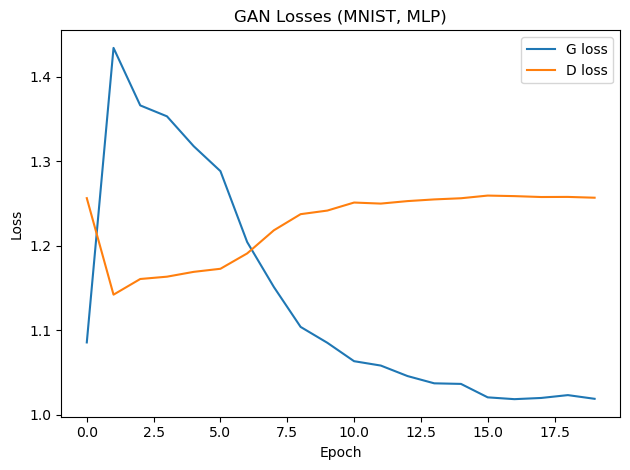

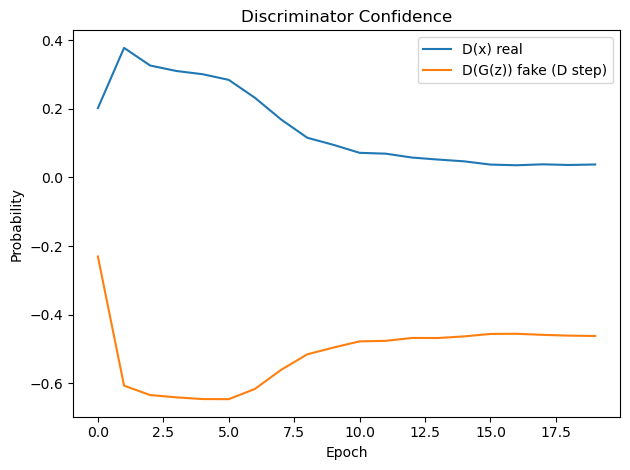

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
from pathlib import Path
import numpy as np

# assumes: Generator, Discriminator, get_mnist_dataloader already defined

device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 100
epochs = 20
lr = 2e-4
betas = (0.5, 0.999)
label_smooth = 0.9         # set to None to disable smoothing
log_interval = 200
outdir = Path("./gan_runs/mlp_mnist")
outdir.mkdir(parents=True, exist_ok=True)

# models
G = Generator(z_dim=z_dim, hidden_dims=(256, 512), use_bn=True).to(device)
D = Discriminator(hidden_dims=(256, 256), p_dropout=0.0).to(device)

# optimizers & loss
opt_G = optim.Adam(G.parameters(), lr=lr, betas=betas)
opt_D = optim.Adam(D.parameters(), lr=lr, betas=betas)
criterion = nn.BCEWithLogitsLoss()

# data
loader = get_mnist_dataloader(batch_size=64, num_workers=2)

# fixed noise for monitoring samples (64 imgs → 8x8 grid)
torch.manual_seed(123)
fixed_z = torch.randn(64, z_dim, device=device)

def real_labels(b):
    if label_smooth is None:
        return torch.ones(b, 1, device=device)
    return torch.full((b, 1), float(label_smooth), device=device)

def fake_labels(b):
    return torch.zeros(b, 1, device=device)

# histories (per-epoch averages)
G_losses, D_losses = [], []
Dx_scores, DGz_scores = [], []   # D(x) on real; D(G(z)) on fake

for epoch in range(1, epochs + 1):
    g_loss_epoch, d_loss_epoch = [], []
    dx_epoch, dgz_epoch = [], []

    for step, (x_real, _) in enumerate(loader, start=1):
        x_real = x_real.to(device)
        bsz = x_real.size(0)

        # -----------------
        # Train D
        # -----------------
        D.zero_grad(set_to_none=True)

        # real
        y_real = real_labels(bsz)
        d_real = D(x_real)                          # D(x)
        d_loss_real = criterion(d_real, y_real)

        # fake (detach for D step)
        z = torch.randn(bsz, z_dim, device=device)
        with torch.no_grad():
            x_fake = G(z)
        y_fake = fake_labels(bsz)
        d_fake = D(x_fake)                          # D(G(z))
        d_loss_fake = criterion(d_fake, y_fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        opt_D.step()

        # -----------------
        # Train G (non-saturating)
        # -----------------
        G.zero_grad(set_to_none=True)
        z = torch.randn(bsz, z_dim, device=device)
        x_fake = G(z)
        g_pred = D(x_fake)
        g_targets = torch.ones(bsz, 1, device=device)  # want D(G(z)) ~ 1
        g_loss = criterion(g_pred, g_targets)
        g_loss.backward()
        opt_G.step()

        # accumulate for per-epoch averages
        g_loss_epoch.append(g_loss.item())
        d_loss_epoch.append(d_loss.item())
        dx_epoch.append(d_real.mean().item())
        # keep both “D on fake during D step” and “D on fake during G step”; we average the former
        dgz_epoch.append(d_fake.mean().item())

        # logging
        if step % log_interval == 0:
            print(
                f"Epoch [{epoch}/{epochs}] "
                f"Step [{step}/{len(loader)}] "
                f"D_loss: {d_loss.item():.4f} (real {d_loss_real.item():.4f} | fake {d_loss_fake.item():.4f}) "
                f"G_loss: {g_loss.item():.4f} "
                f"D(x): {d_real.mean().item():.3f} "
                f"D(G(z)): {d_fake.mean().item():.3f}/{g_pred.mean().item():.3f}"
            )

    # ---------
    # end-of-epoch monitoring
    # ---------
    G_losses.append(float(np.mean(g_loss_epoch)))
    D_losses.append(float(np.mean(d_loss_epoch)))
    Dx_scores.append(float(np.mean(dx_epoch)))
    DGz_scores.append(float(np.mean(dgz_epoch)))

    # sample grid from FIXED noise to visualize progression
    G.eval()
    with torch.no_grad():
        samples = G(fixed_z)          # [-1,1]
        samples = (samples * 0.5) + 0.5
        grid = make_grid(samples, nrow=8, padding=2)
        save_image(grid, outdir / f"samples_epoch_{epoch:03d}.png")
    G.train()

# -----------------
# After training: save curves
# -----------------
plt.figure()
plt.plot(G_losses, label="G loss")
plt.plot(D_losses, label="D loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Losses (MNIST, MLP)")
plt.legend()
plt.tight_layout()
plt.savefig(outdir / "losses.png", dpi=150)

plt.figure()
plt.plot(Dx_scores, label="D(x) real")
plt.plot(DGz_scores, label="D(G(z)) fake (D step)")
plt.xlabel("Epoch")
plt.ylabel("Probability")
plt.title("Discriminator Confidence")
plt.legend()
plt.tight_layout()
plt.savefig(outdir / "discriminator_confidence.png", dpi=150)

print(f"Done. Snapshots & plots saved under: {outdir.resolve()}")


Saved: /Users/aks/Documents/ATML_GIT/PA0/PA0 24280019/Task3_GAN/gan_runs/mlp_mnist/final_grid_5x5.png
Saved: /Users/aks/Documents/ATML_GIT/PA0/PA0 24280019/Task3_GAN/gan_runs/mlp_mnist/losses_report.png


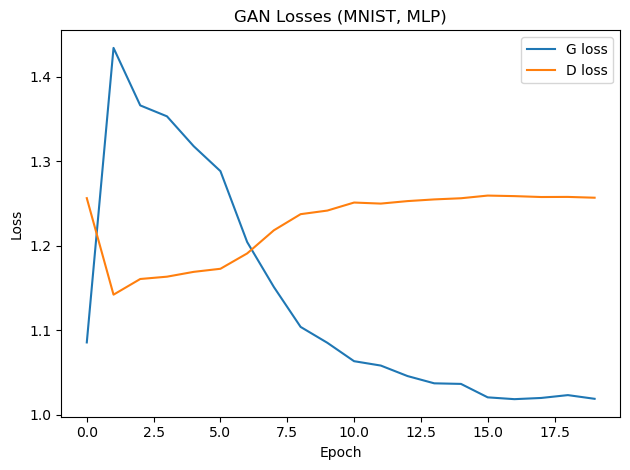

In [26]:
import torch, matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
from pathlib import Path

# --- paths
outdir = Path("./gan_runs/mlp_mnist")
outdir.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 100

# (optional) reload final generator if you trained elsewhere
# from your earlier code: Generator(...)
G = Generator(z_dim=z_dim, hidden_dims=(256,512), use_bn=True).to(device)
G.load_state_dict(torch.load(outdir / "G_final.pt", map_location=device))
G.eval()

# --- 5x5 grid from fresh noise
with torch.no_grad():
    z = torch.randn(25, z_dim, device=device)
    imgs = G(z)                         # [-1,1]
    imgs = (imgs * 0.5) + 0.5           # [0,1] for saving
    grid = make_grid(imgs, nrow=5, padding=2)
    save_image(grid, outdir / "final_grid_5x5.png")
print("Saved:", (outdir / "final_grid_5x5.png").resolve())

# --- Loss curves (if you tracked these lists during training)
# e.g., from the monitoring step: G_losses, D_losses filled per epoch
try:
    plt.figure()
    plt.plot(G_losses, label="G loss")
    plt.plot(D_losses, label="D loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("GAN Losses (MNIST, MLP)")
    plt.legend(); plt.tight_layout()
    plt.savefig(outdir / "losses_report.png", dpi=150)
    print("Saved:", (outdir / "losses_report.png").resolve())
except NameError:
    print("G_losses / D_losses not found. If you didn’t track them, rerun training with histories enabled.")


In [27]:
# --- knobs you can tweak quickly ---
FAST = {
    "z_dim": 100,
    "epochs": 15,              # shorten for demo; increase later
    "batch_size": 64,          # 32–64 CPU, 128–256 GPU if memory allows
    "g_hidden": (256, 512),    # try (128, 256) if slow
    "d_hidden": (256, 256),    # try (256, 128) if slow
    "lr": 2e-4,
    "betas": (0.5, 0.999),
    "label_smooth": 0.9,       # set to None if D underfits
    "log_interval": 300,       # reduce console spam
    "save_every_epoch": True,
}

device = "cuda" if torch.cuda.is_available() else "cpu"

# DataLoader: tweak for throughput
loader = get_mnist_dataloader(
    batch_size=FAST["batch_size"],
    num_workers=2 if device == "cpu" else 4,  # modest workers
)


In [28]:
from torch.cuda.amp import autocast, GradScaler
import torch.nn as nn # Import nn

use_amp = (device == "cuda")
scaler_G = GradScaler(enabled=use_amp)
scaler_D = GradScaler(enabled=use_amp)

# models (re-initialize after changing Discriminator definition)
G = Generator(z_dim=FAST["z_dim"], hidden_dims=FAST["g_hidden"], use_bn=True).to(device)
D = Discriminator(hidden_dims=FAST["d_hidden"], p_dropout=0.0).to(device)

# optimizers & loss
opt_G = optim.Adam(G.parameters(), lr=FAST["lr"], betas=FAST["betas"])
opt_D = optim.Adam(D.parameters(), lr=FAST["lr"], betas=FAST["betas"])
criterion = nn.BCEWithLogitsLoss() # Changed to BCEWithLogitsLoss

# fixed noise for monitoring samples (64 imgs → 8x8 grid)
torch.manual_seed(123)
fixed_z = torch.randn(64, FAST["z_dim"], device=device)


# Note: real_labels and fake_labels now represent targets for BCEWithLogitsLoss,
# which are 1.0 for real and 0.0 for fake. Label smoothing is handled by the
# target values themselves, not the loss function.
def real_labels(bsz: int):
    if FAST["label_smooth"] is None:
        return torch.ones(bsz, 1, device=device)
    # one-sided label smoothing (real labels only)
    return torch.full((bsz, 1), float(FAST["label_smooth"]), device=device)

def fake_labels(bsz: int):
    return torch.zeros(bsz, 1, device=device)


for epoch in range(1, FAST["epochs"] + 1):
    for step, (x_real, _) in enumerate(loader, start=1):
        x_real = x_real.to(device)
        bsz = x_real.size(0)

        # -----------------
        # Train D
        # -----------------
        D.zero_grad(set_to_none=True)
        y_real = real_labels(bsz)
        y_fake = fake_labels(bsz)


        with autocast(enabled=use_amp):
            d_real = D(x_real)
            z = torch.randn(bsz, FAST["z_dim"], device=device)
            with torch.no_grad():
                x_fake = G(z)
            d_fake = D(x_fake)

        # Loss calculation outside of autocast
        d_loss_real = criterion(d_real, y_real)
        d_loss_fake = criterion(d_fake, y_fake)
        d_loss = d_loss_real + d_loss_fake

        scaler_D.scale(d_loss).backward()
        scaler_D.step(opt_D)
        scaler_D.update()

        # -----------------
        # Train G (non-saturating)
        # -----------------
        G.zero_grad(set_to_none=True)
        z = torch.randn(bsz, FAST["z_dim"], device=device)
        with autocast(enabled=use_amp):
            gen = G(z)
            g_pred = D(gen)

        # Loss calculation outside of autocast
        g_target = torch.ones(bsz, 1, device=device)  # non-saturating: want D to think fakes are real
        g_loss = criterion(g_pred, g_target)

        scaler_G.scale(g_loss).backward()
        scaler_G.step(opt_G)
        scaler_G.update()

        # logging (sparser)
        if step % FAST["log_interval"] == 0:
            # To get values in [0, 1] for logging, apply sigmoid manually
            with torch.no_grad():
                # Need to ensure d_real, d_fake, g_pred are tensors before sigmoid
                d_real_sigmoid = torch.sigmoid(d_real).mean().item()
                d_fake_sigmoid = torch.sigmoid(d_fake).mean().item()
                g_pred_sigmoid = torch.sigmoid(g_pred).mean().item()


            print(
                f"Ep[{epoch}/{FAST['epochs']}] St[{step}/{len(loader)}] "
                f"D: {d_loss.item():.4f} (r {d_loss_real.item():.4f} | f {d_loss_fake.item():.4f}) "
                f"G: {g_loss.item():.4f} D(x): {d_real_sigmoid:.3f} D(G(z)): {d_fake_sigmoid:.3f}/{g_pred_sigmoid:.3f}"
            )

    # save per-epoch grid from fixed noise (as you already implemented)
    if FAST["save_every_epoch"]:
        G.eval()
        with torch.no_grad():
            samples = G(fixed_z)    # [-1,1]
            samples = (samples * 0.5) + 0.5
            save_image(make_grid(samples, nrow=8, padding=2),
                       f"./gan_runs/mlp_mnist/samples_epoch_{epoch:03d}.png")
        G.train()

/var/folders/z8/2kn8f9yx2xl_lbczvdd1cz0r0000gn/T/ipykernel_72368/2577387259.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_G = GradScaler(enabled=use_amp)
/var/folders/z8/2kn8f9yx2xl_lbczvdd1cz0r0000gn/T/ipykernel_72368/2577387259.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_D = GradScaler(enabled=use_amp)
/var/folders/z8/2kn8f9yx2xl_lbczvdd1cz0r0000gn/T/ipykernel_72368/2577387259.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/var/folders/z8/2kn8f9yx2xl_lbczvdd1cz0r0000gn/T/ipykernel_72368/2577387259.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Ep[1/15] St[300/938] D: 1.3686 (r 0.6939 | f 0.6747) G: 0.9185 D(x): 0.507 D(G(z)): 0.490/0.400
Ep[1/15] St[600/938] D: 1.2621 (r 0.7551 | f 0.5070) G: 0.9145 D(x): 0.478 D(G(z)): 0.397/0.401
Ep[1/15] St[900/938] D: 1.1494 (r 0.7223 | f 0.4272) G: 1.0856 D(x): 0.503 D(G(z)): 0.344/0.342
Ep[2/15] St[300/938] D: 1.2639 (r 0.5605 | f 0.7034) G: 1.6432 D(x): 0.628 D(G(z)): 0.499/0.199
Ep[2/15] St[600/938] D: 1.2859 (r 0.8965 | f 0.3895) G: 1.0089 D(x): 0.429 D(G(z)): 0.317/0.376
Ep[2/15] St[900/938] D: 1.1033 (r 0.8467 | f 0.2566) G: 0.9457 D(x): 0.468 D(G(z)): 0.224/0.397
Ep[3/15] St[300/938] D: 1.1700 (r 0.5738 | f 0.5962) G: 1.3675 D(x): 0.616 D(G(z)): 0.439/0.267
Ep[3/15] St[600/938] D: 1.2197 (r 0.6235 | f 0.5962) G: 1.4838 D(x): 0.586 D(G(z)): 0.444/0.237
Ep[3/15] St[900/938] D: 1.2240 (r 0.4299 | f 0.7941) G: 1.6697 D(x): 0.744 D(G(z)): 0.530/0.204
Ep[4/15] St[300/938] D: 1.2305 (r 0.4905 | f 0.7401) G: 1.8489 D(x): 0.683 D(G(z)): 0.511/0.166
Ep[4/15] St[600/938] D: 1.1577 (r 0.4359

In [38]:
# --- utilities.py (you can paste into your notebook/script) ---
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Subset
from torchvision.utils import make_grid, save_image
from pathlib import Path
import numpy as np
import math

# assumes: Generator, Discriminator, get_mnist_dataloader, init_weights_normal already defined

def set_seed(seed=123):
    torch.manual_seed(seed)
    np.random.seed(seed)

def make_limited_loader(limit=None, only_class=None, batch_size=64, num_workers=2):
    """Return a DataLoader on a subset of MNIST to induce overfitting."""
    base_loader = get_mnist_dataloader(batch_size=batch_size, num_workers=num_workers)
    ds = base_loader.dataset  # torchvision.datasets.MNIST
    if limit is None and only_class is None:
        return base_loader

    idxs = np.arange(len(ds))
    if only_class is not None:
        # keep only images of a given MNIST digit (0-9)
        keep = [i for i in range(len(ds)) if int(ds[i][1]) == int(only_class)]
        idxs = np.array(keep)

    if limit is not None:
        idxs = idxs[:limit]

    subset = Subset(ds, idxs)
    from torch.utils.data import DataLoader
    return DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

def build_models(g_hidden=(256,512), d_hidden=(256,256), d_dropout=0.0, z_dim=100, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    G = Generator(z_dim=z_dim, hidden_dims=g_hidden, use_bn=True).to(device)
    D = Discriminator(hidden_dims=d_hidden, p_dropout=d_dropout).to(device)
    return G, D, device

@torch.no_grad()
def sample_grid(G, n=25, z_dim=100, device="cpu", path=None, nrow=5):
    z = torch.randn(n, z_dim, device=device)
    imgs = (G(z) * 0.5) + 0.5  # [-1,1] -> [0,1]
    grid = make_grid(imgs, nrow=nrow, padding=2)
    if path:
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        save_image(grid, path)
    return imgs, grid

def mean_pairwise_cosine(x):
    """x: tensor [N,1,28,28] in [0,1]; returns average pairwise cosine similarity (higher => more collapse)."""
    x = x.view(x.size(0), -1)
    x = x - x.mean(dim=1, keepdim=True)
    x = x / (x.norm(dim=1, keepdim=True) + 1e-8)
    sims = x @ x.t()
    n = x.size(0)
    return (sims.sum() - n) / (n*(n-1) + 1e-8)

def pixelwise_std(x):
    """x: [N,1,28,28] in [0,1]; global pixel std as a simple diversity proxy."""
    return x.std().item()


In [39]:
# --- train_experiment.py ---
import torch, torch.nn as nn, torch.optim as optim
from pathlib import Path
import numpy as np
from torchvision.utils import save_image, make_grid
# from utilities import (set_seed, build_models, sample_grid, mean_pairwise_cosine, pixelwise_std)

def run_gan_experiment(
    outdir="./gan_runs/exp",
    epochs=10,
    z_dim=100,
    batch_size=64,
    dl=None,                      # pass a DataLoader; if None, call get_mnist_dataloader() before use
    # capacity & regularization
    g_hidden=(256,512),
    d_hidden=(256,256),
    d_dropout=0.0,
    # optimization knobs
    lr_g=2e-4, lr_d=2e-4,
    betas=(0.5, 0.999),
    d_steps=1, g_steps=1,         # training ratio per batch
    label_smooth=None,            # e.g., 0.9 for real labels
    use_non_saturating=True,      # True => BCE(D(G(z)), 1); False => minimize log(1 - D(G(z)))
    seed=123,
    log_interval=200
):
    set_seed(seed)
    Path(outdir).mkdir(parents=True, exist_ok=True)
    G, D, device = build_models(g_hidden=g_hidden, d_hidden=d_hidden, d_dropout=d_dropout, z_dim=z_dim)

    opt_G = optim.Adam(G.parameters(), lr=lr_g, betas=betas)
    opt_D = optim.Adam(D.parameters(), lr=lr_d, betas=betas)
    criterion = nn.BCEWithLogitsLoss() # Changed to BCEWithLogitsLoss

    fixed_z = torch.randn(64, z_dim, device=device)

    G_losses, D_losses, Dx_hist, DGz_hist = [], [], [], []

    for ep in range(1, epochs+1):
        g_loss_acc, d_loss_acc, dx_acc, dgz_acc = [], [], [], []

        for step, (x_real, _) in enumerate(dl, start=1):
            x_real = x_real.to(device)
            bsz = x_real.size(0)

            # -------- D steps --------
            for _ in range(d_steps):
                D.zero_grad(set_to_none=True)
                # real pass
                y_real = torch.ones(bsz, 1, device=device) if label_smooth is None else torch.full((bsz,1), float(label_smooth), device=device)
                d_real = D(x_real)
                d_loss_real = criterion(d_real, y_real)

                # fake pass (detach G)
                z = torch.randn(bsz, z_dim, device=device)
                with torch.no_grad():
                    x_fake = G(z)
                y_fake = torch.zeros(bsz, 1, device=device)
                d_fake = D(x_fake)
                d_loss_fake = criterion(d_fake, y_fake)

                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                opt_D.step()

            # -------- G steps --------
            for _ in range(g_steps):
                G.zero_grad(set_to_none=True)
                z = torch.randn(bsz, z_dim, device=device)
                gen = G(z)
                d_pred = D(gen)
                if use_non_saturating:
                    # maximize log D(G(z)) == minimize BCE(D(G(z)), 1)
                    g_targets = torch.ones(bsz, 1, device=device)
                    g_loss = criterion(d_pred, g_targets)
                else:
                    # original minimax: minimize log(1 - D(G(z))) (we compute BCE to 0)
                    g_targets = torch.zeros(bsz, 1, device=device)
                    g_loss = criterion(d_pred, g_targets)
                g_loss.backward()
                opt_G.step()

            # --- logging stats (use the last D pass as proxy) ---
            g_loss_acc.append(g_loss.item())
            d_loss_acc.append(d_loss.item())
            dx_acc.append(d_real.mean().item())
            dgz_acc.append(d_fake.mean().item())

            if step % log_interval == 0:
                # Apply sigmoid manually for logging to get values in [0, 1]
                with torch.no_grad():
                    d_real_sigmoid = torch.sigmoid(d_real).mean().item()
                    d_fake_sigmoid = torch.sigmoid(d_fake).mean().item()
                    d_pred_sigmoid = torch.sigmoid(d_pred).mean().item() # Use d_pred for G step prediction

                print(f"Ep[{ep}/{epochs}] St[{step}/{len(dl)}] "
                      f"D: {d_loss.item():.4f} (r {d_loss_real.item():.4f}|f {d_loss_fake.item():.4f}) "
                      f"G: {g_loss.item():.4f} D(x): {d_real_sigmoid:.3f} D(G(z)): {d_fake_sigmoid:.3f}/{d_pred_sigmoid:.3f}")


        # epoch aggregates
        G_losses.append(float(np.mean(g_loss_acc)))
        D_losses.append(float(np.mean(d_loss_acc)))
        Dx_hist.append(float(np.mean(dx_acc)))
        DGz_hist.append(float(np.mean(dgz_acc)))

        # save epoch samples from fixed noise
        G.eval()
        with torch.no_grad():
            imgs = (G(fixed_z)*0.5)+0.5
            save_image(make_grid(imgs, nrow=8, padding=2), f"{outdir}/samples_ep{ep:03d}.png")
        G.train()

    # final artifacts + a 5x5 fresh grid
    torch.save(G.state_dict(), f"{outdir}/G_final.pt")
    torch.save(D.state_dict(), f"{outdir}/D_final.pt")
    _imgs, _ = sample_grid(G, n=25, z_dim=z_dim, device=device, path=f"{outdir}/final_grid_5x5.png", nrow=5)

    # quick diversity readout on the final fixed batch (not a full metric, but useful)
    with torch.no_grad():
        probe_imgs, _ = sample_grid(G, n=64, z_dim=z_dim, device=device, path=None, nrow=8)
        cos_sim = mean_pairwise_cosine(probe_imgs)  # higher => more collapse
        px_std = pixelwise_std(probe_imgs)          # lower => more collapse
    np.savez(f"{outdir}/history.npz",
             G_losses=G_losses, D_losses=D_losses, Dx=Dx_hist, DGz=DGz_hist,
             cos_sim=float(cos_sim), px_std=float(px_std))
    print(f"[Saved] {outdir} | cos_sim={cos_sim:.3f} (lower better) px_std={px_std:.3f} (higher better)")
    return dict(G_losses=G_losses, D_losses=D_losses, Dx=Dx_hist, DGz=DGz_hist,
                cos_sim=float(cos_sim), px_std=float(px_std))

In [31]:
# ---- induce vanishing gradients ----
# from train_experiment import run_gan_experiment
# from utilities import make_limited_loader
dl = make_limited_loader(limit=None, only_class=None, batch_size=64)  # full MNIST

# Overpower D
res_vanish = run_gan_experiment(
    outdir="./gan_runs/vanish/overpowerD",
    epochs=10, dl=dl,
    g_hidden=(256,512), d_hidden=(512,512),
    lr_g=2e-4, lr_d=1e-3,       # D learns much faster
    d_steps=5, g_steps=1,       # multiple D updates
    label_smooth=None,          # OFF (to make it worse)
    use_non_saturating=False,   # original minimax (weaker gradients) to exacerbate the issue
    seed=1
)


Ep[1/10] St[200/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[1/10] St[400/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[1/10] St[600/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[1/10] St[800/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[2/10] St[200/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[2/10] St[400/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[2/10] St[600/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[2/10] St[800/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[3/10] St[200/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[3/10] St[400/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000 D(x): 1.000 D(G(z)): 0.000/0.000
Ep[3/10] St[600/938] D: 0.0000 (r 0.0000|f 0.0000) G: 0.0000

In [32]:
# ---- mitigate vanishing gradients ----
res_vanish_fix = run_gan_experiment(
    outdir="./gan_runs/vanish/fixed",
    epochs=10, dl=dl,
    g_hidden=(256,512), d_hidden=(512,512),
    lr_g=2e-4, lr_d=2e-4,       # back to balanced
    d_steps=1, g_steps=1,
    label_smooth=0.9,           # keep D uncertain
    use_non_saturating=True,    # stronger gradients for G
    seed=1
)


Ep[1/10] St[200/938] D: 1.4121 (r 0.4552|f 0.9569) G: 1.1481 D(x): 0.694 D(G(z)): 0.615/0.319
Ep[1/10] St[400/938] D: 1.2527 (r 0.3868|f 0.8659) G: 1.4417 D(x): 0.784 D(G(z)): 0.566/0.241
Ep[1/10] St[600/938] D: 1.0224 (r 0.7585|f 0.2639) G: 1.4979 D(x): 0.501 D(G(z)): 0.229/0.237
Ep[1/10] St[800/938] D: 1.0861 (r 0.3934|f 0.6927) G: 2.3283 D(x): 0.790 D(G(z)): 0.494/0.099
Ep[2/10] St[200/938] D: 0.9829 (r 0.7305|f 0.2525) G: 1.1246 D(x): 0.524 D(G(z)): 0.220/0.340
Ep[2/10] St[400/938] D: 0.8890 (r 0.5083|f 0.3808) G: 2.0607 D(x): 0.688 D(G(z)): 0.311/0.135
Ep[2/10] St[600/938] D: 1.1369 (r 0.3536|f 0.7832) G: 2.0871 D(x): 0.867 D(G(z)): 0.531/0.133
Ep[2/10] St[800/938] D: 0.9283 (r 0.6395|f 0.2888) G: 1.4694 D(x): 0.603 D(G(z)): 0.247/0.242
Ep[3/10] St[200/938] D: 1.1120 (r 0.9366|f 0.1754) G: 0.9697 D(x): 0.439 D(G(z)): 0.159/0.393
Ep[3/10] St[400/938] D: 0.9809 (r 0.5716|f 0.4093) G: 1.6641 D(x): 0.639 D(G(z)): 0.328/0.207
Ep[3/10] St[600/938] D: 0.9796 (r 0.5729|f 0.4067) G: 1.4732

In [33]:
# ---- induce mode collapse ----
res_collapse = run_gan_experiment(
    outdir="./gan_runs/collapse/overpowerG",
    epochs=12, dl=dl,
    g_hidden=(256,512), d_hidden=(128,128),
    lr_g=1e-3, lr_d=2e-4,
    g_steps=5, d_steps=1,
    label_smooth=None,
    use_non_saturating=True,
    seed=2
)


Ep[1/12] St[200/938] D: 1.3890 (r 0.6919|f 0.6972) G: 0.6900 D(x): 0.501 D(G(z)): 0.502/0.502
Ep[1/12] St[400/938] D: 1.3893 (r 0.6767|f 0.7125) G: 0.6754 D(x): 0.508 D(G(z)): 0.510/0.509
Ep[1/12] St[600/938] D: 1.3864 (r 0.6924|f 0.6940) G: 0.6915 D(x): 0.500 D(G(z)): 0.500/0.501
Ep[1/12] St[800/938] D: 1.3870 (r 0.6979|f 0.6891) G: 0.6978 D(x): 0.498 D(G(z)): 0.498/0.498
Ep[2/12] St[200/938] D: 1.3869 (r 0.6944|f 0.6926) G: 0.6947 D(x): 0.499 D(G(z)): 0.500/0.499
Ep[2/12] St[400/938] D: 1.3862 (r 0.6898|f 0.6964) G: 0.6903 D(x): 0.502 D(G(z)): 0.502/0.501
Ep[2/12] St[600/938] D: 1.3871 (r 0.6931|f 0.6940) G: 0.6923 D(x): 0.500 D(G(z)): 0.500/0.500
Ep[2/12] St[800/938] D: 1.3864 (r 0.6947|f 0.6916) G: 0.6946 D(x): 0.499 D(G(z)): 0.499/0.499
Ep[3/12] St[200/938] D: 1.3867 (r 0.6923|f 0.6944) G: 0.6920 D(x): 0.500 D(G(z)): 0.501/0.501
Ep[3/12] St[400/938] D: 1.3864 (r 0.6929|f 0.6935) G: 0.6931 D(x): 0.500 D(G(z)): 0.500/0.500
Ep[3/12] St[600/938] D: 1.3862 (r 0.6928|f 0.6934) G: 0.6928

In [34]:
# ---- mitigate collapse ----
res_collapse_fix = run_gan_experiment(
    outdir="./gan_runs/collapse/fixed",
    epochs=12, dl=dl,
    g_hidden=(256,512), d_hidden=(256,256),
    lr_g=2e-4, lr_d=2e-4,
    g_steps=1, d_steps=2,
    label_smooth=0.9,            # optional; helps stabilize D
    use_non_saturating=True,
    seed=2
)


Ep[1/12] St[200/938] D: 1.0527 (r 0.7768|f 0.2759) G: 1.0697 D(x): 0.480 D(G(z)): 0.240/0.346
Ep[1/12] St[400/938] D: 1.1739 (r 1.0775|f 0.0964) G: 1.1139 D(x): 0.366 D(G(z)): 0.092/0.339
Ep[1/12] St[600/938] D: 0.7886 (r 0.5762|f 0.2124) G: 1.3850 D(x): 0.619 D(G(z)): 0.189/0.261
Ep[1/12] St[800/938] D: 0.8557 (r 0.6750|f 0.1807) G: 1.3805 D(x): 0.596 D(G(z)): 0.162/0.271
Ep[2/12] St[200/938] D: 0.7871 (r 0.6843|f 0.1028) G: 1.6378 D(x): 0.581 D(G(z)): 0.096/0.216
Ep[2/12] St[400/938] D: 0.8964 (r 0.6959|f 0.2005) G: 1.3492 D(x): 0.558 D(G(z)): 0.178/0.280
Ep[2/12] St[600/938] D: 0.8857 (r 0.7639|f 0.1218) G: 1.4105 D(x): 0.547 D(G(z)): 0.113/0.271
Ep[2/12] St[800/938] D: 0.9845 (r 0.8107|f 0.1738) G: 0.9962 D(x): 0.523 D(G(z)): 0.155/0.385
Ep[3/12] St[200/938] D: 0.9144 (r 0.6887|f 0.2256) G: 1.2530 D(x): 0.565 D(G(z)): 0.195/0.323
Ep[3/12] St[400/938] D: 0.9299 (r 0.7668|f 0.1631) G: 1.1180 D(x): 0.536 D(G(z)): 0.146/0.356
Ep[3/12] St[600/938] D: 0.8432 (r 0.5363|f 0.3069) G: 1.8462

In [35]:

# very small dataset (e.g., only 800 examples)
small_dl = make_limited_loader(limit=800, only_class=None, batch_size=64)

# ---- induce overfitting ----
res_overfit = run_gan_experiment(
    outdir="./gan_runs/overfit/induce",
    epochs=20, dl=small_dl,
    g_hidden=(256,512),
    d_hidden=(512,512,256),
    d_dropout=0.0,
    lr_g=2e-4, lr_d=2e-4,
    d_steps=1, g_steps=1,
    label_smooth=None,
    use_non_saturating=True,
    seed=3
)


[Saved] ./gan_runs/overfit/induce | cos_sim=0.684 (lower better) px_std=0.204 (higher better)


In [36]:
# ---- mitigate overfitting ----
res_overfit_fix = run_gan_experiment(
    outdir="./gan_runs/overfit/fixed",
    epochs=20, dl=small_dl,
    g_hidden=(256,512),
    d_hidden=(256,256),      # smaller D
    d_dropout=0.4,           # regularize
    lr_g=2e-4, lr_d=2e-4,
    d_steps=1, g_steps=1,
    label_smooth=0.9,
    use_non_saturating=True,
    seed=3
)


[Saved] ./gan_runs/overfit/fixed | cos_sim=0.827 (lower better) px_std=0.209 (higher better)


In [37]:
import numpy as np, matplotlib.pyplot as plt, os

def plot_compare(runs, labels, outpath):
    plt.figure()
    for run, label in zip(runs, labels):
        h = np.load(os.path.join(run, "history.npz"), allow_pickle=True)
        plt.plot(h["G_losses"], label=f"G {label}")
        plt.plot(h["D_losses"], label=f"D {label}", linestyle="--")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("GAN Losses")
    plt.legend(); plt.tight_layout(); plt.savefig(outpath, dpi=150); plt.close()

# examples:
plot_compare(
    ["./gan_runs/vanish/overpowerD", "./gan_runs/vanish/fixed"],
    ["vanish", "fixed"],
    "./gan_runs/vanish/compare_losses.png"
)

plot_compare(
    ["./gan_runs/collapse/overpowerG", "./gan_runs/collapse/fixed"],
    ["collapse", "fixed"],
    "./gan_runs/collapse/compare_losses.png"
)
